In [1]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import numpy as np

In [2]:
stocks=["AAPL", "MSFT"]
data = yf.download(stocks, start="2019-01-01", end="2023-12-31")['Close']


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


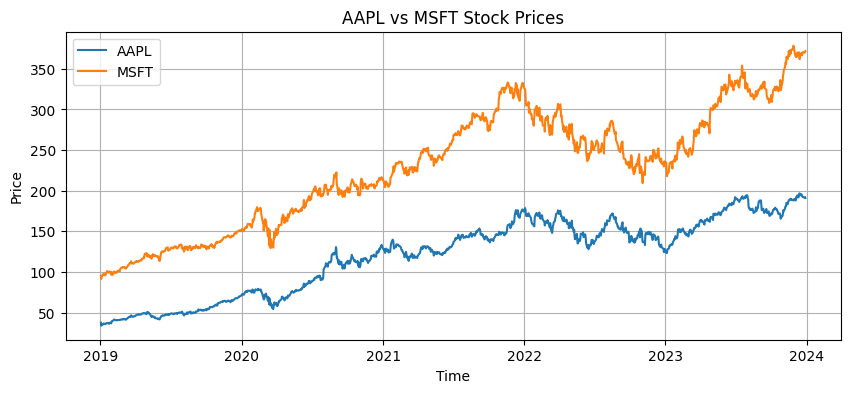

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
apple = data['AAPL']
microsoft = data['MSFT']

plt.plot(apple, label="AAPL")
plt.plot(microsoft, label="MSFT")
plt.legend()
plt.title("AAPL vs MSFT Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Spread between APPL and MSFT')

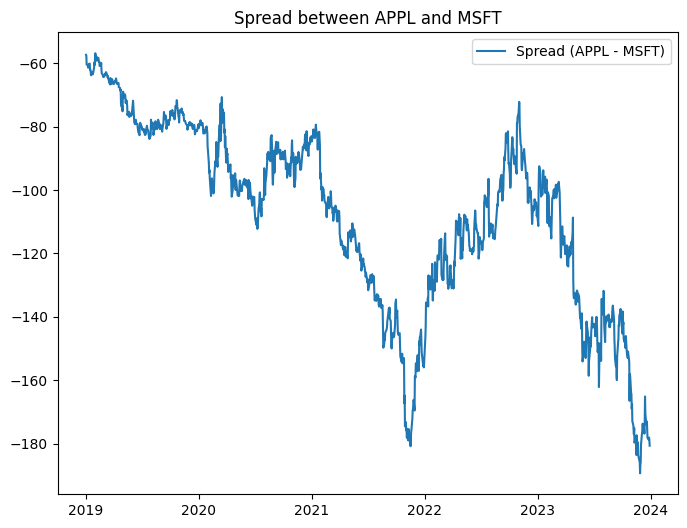

In [4]:
plt.figure(figsize=(8, 6))
plt.plot(apple - microsoft, label = 'Spread (APPL - MSFT)')
plt.legend()
plt.title("Spread between APPL and MSFT")

In [5]:
import statsmodels.tsa.stattools as ts
result = ts.coint(apple, microsoft)
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('P value for cointegration test is', p_val)

P value for cointegration test is 0.3672452087890925


Text(0.5, 1.0, 'Price Ratio between apple and MSFT')

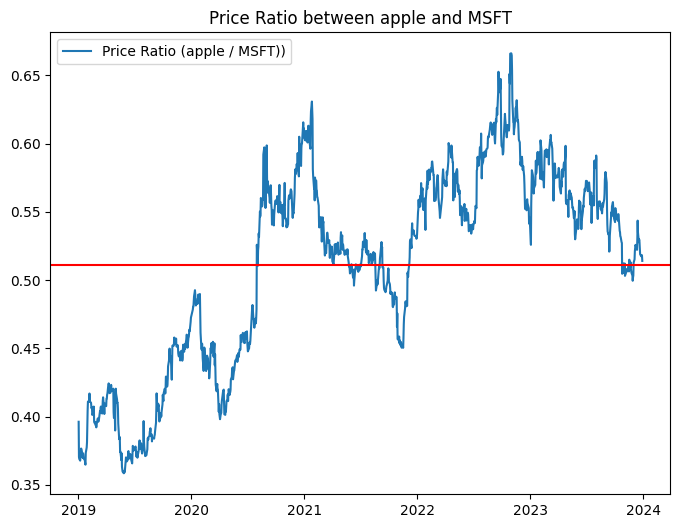

In [6]:
plt.figure(figsize=(8, 6))
ratio = apple / microsoft
plt.plot(ratio, label = 'Price Ratio (apple / MSFT))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between apple and MSFT")


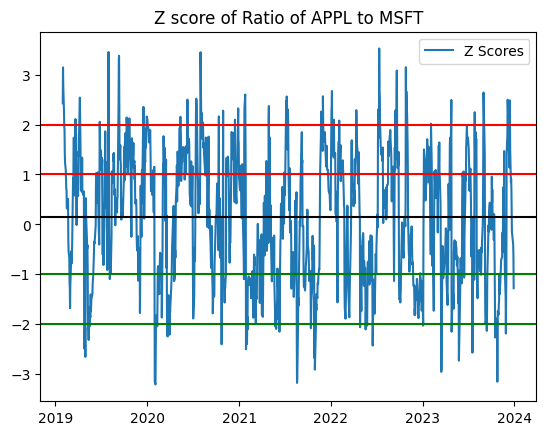

In [7]:
zscore = (ratio - ratio.rolling(window=20).mean()) / ratio.rolling(window=20).std()
plt.plot(zscore, label = "Z Scores")
plt.axhline(zscore.mean(), color = 'black')
plt.axhline(1.0, color='red')
plt.axhline(2, color='red')
plt.axhline(-1.0, color='green')
plt.axhline(-2, color='green')
plt.legend(loc = 'best')
plt.title('Z score of Ratio of APPL to MSFT')
plt.show()

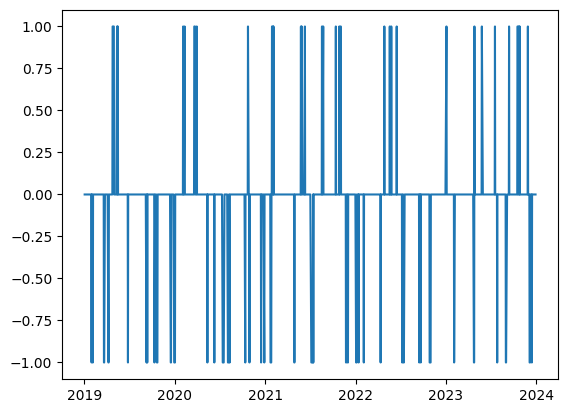

In [8]:
#for rolling mean window number of days.
lookback = 20
threshold_entry = 2
threshold_exit = 2

data['ratio'] = data['AAPL'] / data['MSFT']

#for rolling mean and standard mean calculation for zscore.

data['rolling_mean'] = data['ratio'].rolling(window=lookback).mean()
data['rolling_std'] = data['ratio'].rolling(window=lookback).std()

# z-score.
data['zscore'] = (data['ratio'] - data['rolling_mean']) / data['rolling_std']

# Generating signals based on z score for each day.
data['signal'] = 0
data.loc[data['zscore'] < -threshold_entry, 'signal'] = 1   # Buy signal
data.loc[data['zscore'] > threshold_exit, 'signal'] = -1   # Sell signal

#added parameter for stoploss for +-2.7.
stop_loss= 2.7
data['signal'] = np.where(abs(data['zscore']) > stop_loss, 0, data['signal'])

# exit using flattening signal to 0.
data.loc[(data['zscore'] > -threshold_exit) & (data['zscore'] < threshold_exit), 'signal'] = 0
data['signal']
plt.plot(data['signal'])

In [9]:
#backtesting
import numpy as np
data['AAPL_daily_returns'] = data['AAPL'].pct_change()
data['MSFT_daily_returns'] = data['MSFT'].pct_change()
data['strat_returns']=data['signal'].shift(1) * (data['AAPL_daily_returns'] - data['MSFT_daily_returns'])
data['cumulative_returns'] = (1 + data['strat_returns']).cumprod()

#performance metrics
total_return = data['cumulative_returns'].iloc[-1] - 1

years = len(data) / 252  # Trading days per year

annualized_return = (data['cumulative_returns'].iloc[-1] ** (1/years)) - 1
annualized_vol = data['strat_returns'].std() * np.sqrt(252)

#calculatig sharpe while considering zero risk free rate
sharpe_ratio = (annualized_return ) / annualized_vol

#max
cumulative_max = data['cumulative_returns'].cummax()
drawdown = (data['cumulative_returns'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()
winning_trades = data[data['strat_returns'] > 0]
win_rate = len(winning_trades) / len(data[data['signal'].shift(1) != 0])

results = {
    "Total Return": total_return,
    "Annualized Return": annualized_return,
    "Annualized Volatility": annualized_vol,
    "Sharpe Ratio": sharpe_ratio,
    "Max Drawdown": max_drawdown,
    "Win Rate": win_rate,
}

pd.DataFrame(results, index=["Performance"])

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Win Rate
Performance,0.489742,0.083122,0.079311,1.048045,-0.05259,0.570175


                       Performance
Total Return              0.489742
Annualized Return         0.083122
Annualized Volatility     0.079311
Sharpe Ratio              1.048045
Max Drawdown             -0.052590
Win Rate                  0.570175


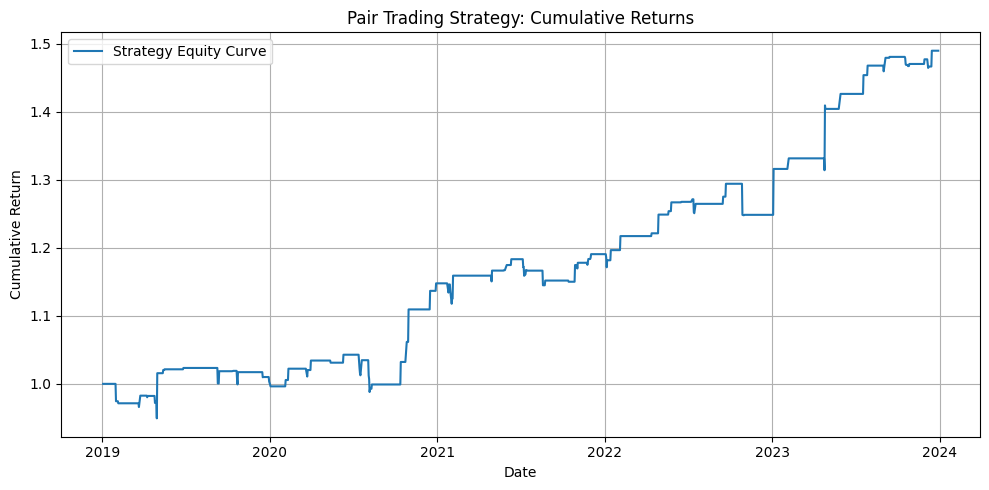

In [10]:

# Display results
performance_df = pd.DataFrame(results, index=["Performance"]).T
print(performance_df)

# Optional: Plot equity curve
plt.figure(figsize=(10, 5))
plt.plot(data['cumulative_returns'], label='Strategy Equity Curve')
plt.title('Pair Trading Strategy: Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
